In [1]:
import warnings; warnings.filterwarnings('ignore')

import pandas as pd 
import json
from pathlib import Path

from collections import OrderedDict
import numpy as np

import re
from collections import defaultdict

import spacy
from spacy.matcher import PhraseMatcher
from spacy.pipeline import EntityRuler

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from yellowbrick.text import TSNEVisualizer, FreqDistVisualizer, dispersion

import matplotlib.pyplot as plt
%matplotlib inline 

BASE_PATH = Path('../..')
events_path = BASE_PATH / 'events'
dictionary_path = BASE_PATH / 'dictionary'
data_path = BASE_PATH / 'data'
subset_reports_path = data_path / 'subset'
subset_reports_path_txt = data_path / 'subset_txt'
df_path = data_path / 'dataframes'
patterns_path = dictionary_path / 'patterns'
triggers_path = dictionary_path / 'trigger phrases'

In [42]:
nlp = spacy.load("en_core_web_lg")

In [43]:
patterns = []
for p in patterns_path.glob('*.json'):
    with open(p, encoding="utf8") as f:
        patterns += json.load(f)
        
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)
nlp.add_pipe(ruler)

In [44]:
triggers = []

for p in triggers_path.glob('*.txt'):
    with open(p, 'r') as f:
        for line in f:
            if len(line) > 1:
                triggers.append(line[:-2].split())

patterns = [nlp(' '.join(phrase)) for phrase in triggers]
phrase_matcher = PhraseMatcher(nlp.vocab)
phrase_matcher.add("NearMissEvent", None, *patterns)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def show_freq(text):
    if isinstance(text, str):
        text = text.split()
        
    vectorizer = CountVectorizer()
    corpus = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names()

    plt.figure(figsize=(12,12))
    visualizer = FreqDistVisualizer(features=features, orient='h')
    visualizer.fit(corpus)
    visualizer.show();

In [50]:
def clean(text):
    text = text.strip('[(),- :\'\"\n]\s*').lower()
    # text = re.sub('([A-Za-z0-9\)]{2,}\.)([A-Z]+[a-z]*)', r"\g<1> \g<2>", text, flags=re.UNICODE)
    text = re.sub('\s+', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('","', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('-', ' ', text, flags=re.UNICODE).strip()
    # text = re.sub('\(', ' ', text, flags=re.UNICODE).strip()
    # text = re.sub('\)', ' ', text, flags=re.UNICODE).strip()
    text = re.sub('\/', ' ', text, flags=re.UNICODE).strip()
    text = text.replace("\\", ' ')

    text = ' '.join(text.split())

    if (text[len(text) - 1] != '.'):
        text += '.'

    return text

def get_tokens(doc):
    return ' '.join([w.lemma_ for w in doc if (w.is_alpha and not w.is_stop)])

def get_extracted_geology_ents(text):
    extracted_ents_dict = defaultdict(set)

    for ent in text.ents:
        label = ent.label_
        if label in ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']:
            extracted_ents_dict[label].add(ent.text)

    result = {}
    for k, v in extracted_ents_dict.items():
        values = ', '.join(v) if len(v) > 0 else ''
        result[k] = values

    return result

In [ ]:
for filename in subset_reports_path.glob('*.json'):
    
    with open(filename, 'r') as f:
        text = json.load(f)
        
    if len(text) == 0:
        continue
        
    text = ' '.join(text)
    
    out_file = subset_reports_path_txt / filename.with_suffix('.txt').name
    
    with open(out_file, 'w') as f:
        f.write(text)

In [80]:
data = []

a_pattern = re.compile('(a\d*)_')
e_pattern = re.compile('_(e\d*)_')

for filename in subset_reports_path_txt.glob('*.txt'):
    
    with open(filename, 'r') as f:
        text = f.read()
          
    clean_text = clean(text)
    doc = nlp(clean_text)
    tokens = get_tokens(doc)
    ent_dict = get_extracted_geology_ents(doc)
            
    name = filename.with_suffix('').name
    
    a_match = a_pattern.match(name)
    
    if a_match is not None:
        a = a_match[0]
    else:
        a = ''
    
    e_match = e_pattern.match(name)
    
    if e_match is not None:
        e = e_match[0]
    else:
        e = ''
    
    data.append({
        'name': name,
        'a': a,
        'e': e,
        'text': text,
        'clean_text': clean_text,
        'tokens': tokens,
        **ent_dict
    })
    
df = pd.DataFrame(data)

In [81]:
df.head()

,name,a,e,text,clean_text,tokens,STRAT,TIMESCALE,LOCATION,ROCK,MINERAL,ORE_DEPOSIT
0,a080918_e9_1443_annual_09_13904956,a080918_,None,Following the completion of the hole and loggi...,following the completion of the hole and loggi...,follow completion hole logging core lack evapo...,"dirk hartog formation, tumblagooda sandstone","holocene, silurian, ordovician, permian, preca...","perth, genesis, gascoyne junction, carnarvon b...","dolostone, evaporite, evaporites, limestone, s...","anhydrite, dolomite, halite, salts, sylvite, d...",NaN
1,a079788_e15_852_2008a_11529818,a079788_,None,RC/Diamond Drilling Collar File RC/Diamond Dri...,rc diamond drilling collar file rc diamond dri...,rc diamond drilling collar file rc diamond dri...,NaN,"archaean, cainozoic","kambalda, long, western australia, kalgoorlie ...","basalts, basalt, porphyry, greenstones, bedroc...","american, diamond, salt, sulphide",NaN
2,a080325_fig 1 p28.1018_14675736,a080325_,None,320000 340000 360000 380000 400000 420000 6600...,320000 340000 360000 380000 400000 420000 6600...,scale lake emu lindsays project kalpini projec...,NaN,NaN,"esperance, victoria, western australia, lavert...",NaN,"gold, nickel, silver",NaN
3,a077471_e47_1265_2008a_10539959,a077471_,None,The Hamersley Province has undergone a complex...,the hamersley province has undergone a complex...,hamersley province undergo complex deformation...,"yandicoogina shale members, brockman iron form...","cainozoic, tertiary, archaean, proterozoic","genesis, western australia, newman, pilbara re...","felsic volcanic rocks, colluviums, carbonate r...","dolomite, diamonds, martite, goethite, iron","iron deposits, detrital iron deposits, cids, b..."
4,a082214_figure 1 tenure__15553798,a082214_,None,and composition of any Native Title Claims sho...,and composition of any native title claims sho...,composition native title claim seek land claim...,NaN,NaN,australia,NaN,NaN,NaN


In [54]:
filename = df_path / 'subset_data.csv'
df.to_csv(filename, index=False)

In [55]:
corpus = [doc.split() for doc in df.tokens]

all_words_list = []
for words in corpus:
    all_words_list += words
    
all_words = ' '.join(all_words_list)

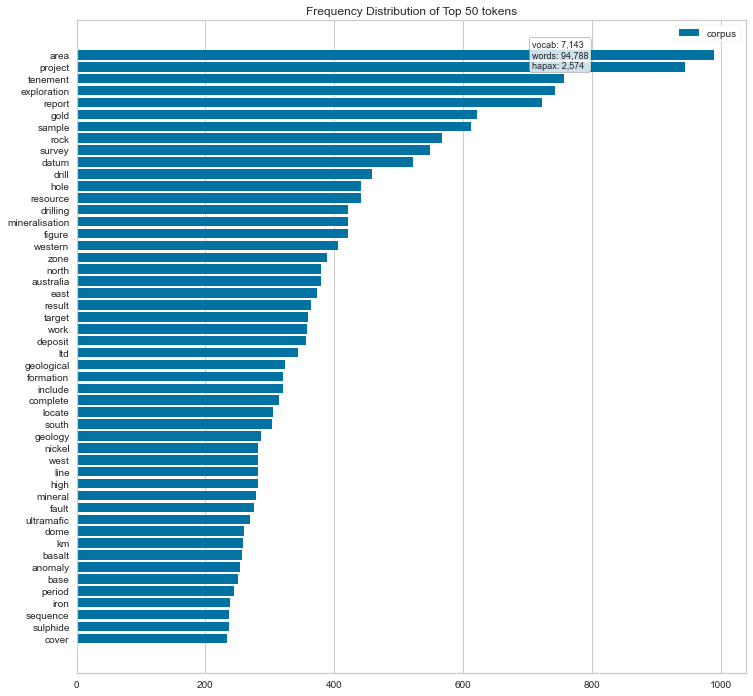

In [56]:
show_freq(all_words)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


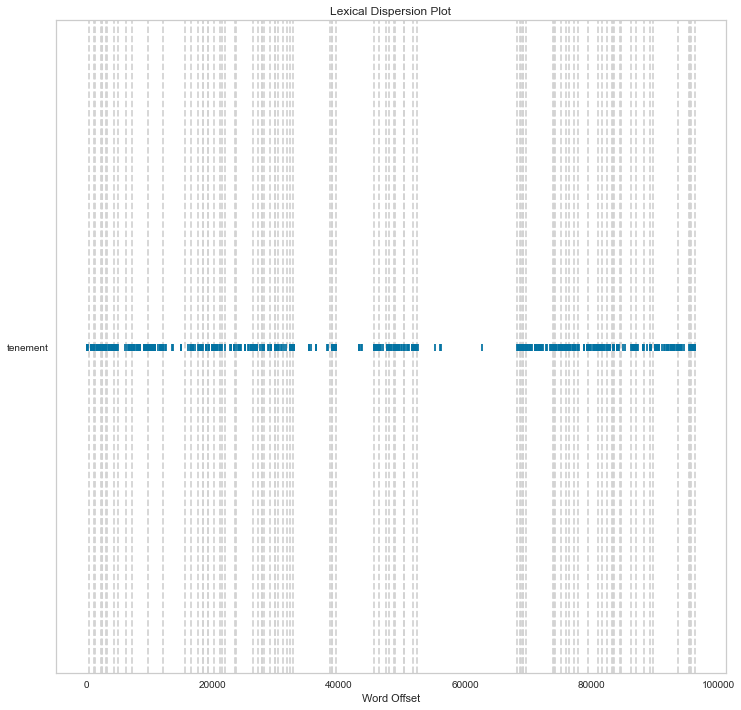

In [59]:
plt.figure(figsize=(12,12))
dispersion(['tenement'], corpus, annotate_docs=True);

In [ ]:
def get_tenement(text, n=3):
    result = []
    words = text.split()
    for i, word in enumerate(words):
        if word == 'tenement':
            low = max(0, i-n)
            high = min(len(words) - 1, i+n)
            result.append(' '.join(words[low: high]))
    return ', '.join(result)

In [66]:
df['tenements'] = df['tokens'].apply(get_tenement)

In [67]:
df['tenements'] = df['tokens'].apply(get_tenement)

In [68]:
df.head()

,name,text,clean_text,tokens,STRAT,TIMESCALE,LOCATION,ROCK,MINERAL,ORE_DEPOSIT,tenements
0,a080918_e9_1443_annual_09_13904956,Following the completion of the hole and loggi...,following the completion of the hole and loggi...,follow completion hole logging core lack evapo...,"dirk hartog formation, tumblagooda sandstone","holocene, silurian, ordovician, permian, preca...","perth, genesis, gascoyne junction, carnarvon b...","dolostone, evaporite, evaporites, limestone, s...","anhydrite, dolomite, halite, salts, sylvite, d...",NaN,[zone downgrade potential tenement host potash...
1,a079788_e15_852_2008a_11529818,RC/Diamond Drilling Collar File RC/Diamond Dri...,rc diamond drilling collar file rc diamond dri...,rc diamond drilling collar file rc diamond dri...,NaN,"archaean, cainozoic","kambalda, long, western australia, kalgoorlie ...","basalts, basalt, porphyry, greenstones, bedroc...","american, diamond, salt, sulphide",NaN,"[swager archaean rock tenement lie form, felsi..."
2,a080325_fig 1 p28.1018_14675736,320000 340000 360000 380000 400000 420000 6600...,320000 340000 360000 380000 400000 420000 6600...,scale lake emu lindsays project kalpini projec...,NaN,NaN,"esperance, victoria, western australia, lavert...",NaN,"gold, nickel, silver",NaN,"[boulder carrick gold tenement legend western,..."
3,a077471_e47_1265_2008a_10539959,The Hamersley Province has undergone a complex...,the hamersley province has undergone a complex...,hamersley province undergo complex deformation...,"yandicoogina shale members, brockman iron form...","cainozoic, tertiary, archaean, proterozoic","genesis, western australia, newman, pilbara re...","felsic volcanic rocks, colluviums, carbonate r...","dolomite, diamonds, martite, goethite, iron","iron deposits, detrital iron deposits, cids, b...",[conduct exploration south tenement respective...
4,a082214_figure 1 tenure__15553798,and composition of any Native Title Claims sho...,and composition of any native title claims sho...,composition native title claim seek land claim...,NaN,NaN,australia,NaN,NaN,NaN,[supply applicant mining tenement responsibili...
